# In-class exercise 5

In [1]:
# Common imports
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib notebook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

# to make this notebook's output identical at every run
np.random.seed(42)

In [2]:
# Scikit-Learn ≥0.20 is required
import sklearn

This exercise aims to predict the price of an airbnb listing in New York City.
The dataset is available on [Kaggle](https://www.kaggle.com/datasets/dgawlik/airbnb-price-prediction).

## Question 1: set up

### Load the airbnb dataset for NY

In [3]:
df = pd.read_csv("airbnbNY.csv")

In [4]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## Question 2: Exploratory Data Analysis 
You should start by performing simple steps to understand the data (and make sure that it is clean).
- Check the number of rows and columns
- Deal with missing values 
- Look for outliers (especially in the `y` column)

#### Look for `NA` values in the dataset

In [5]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Deal with them by removing the rows with `NA` values.

In [6]:
df = df.dropna()
df.shape

(38821, 16)

### Quantity to predict= `price`

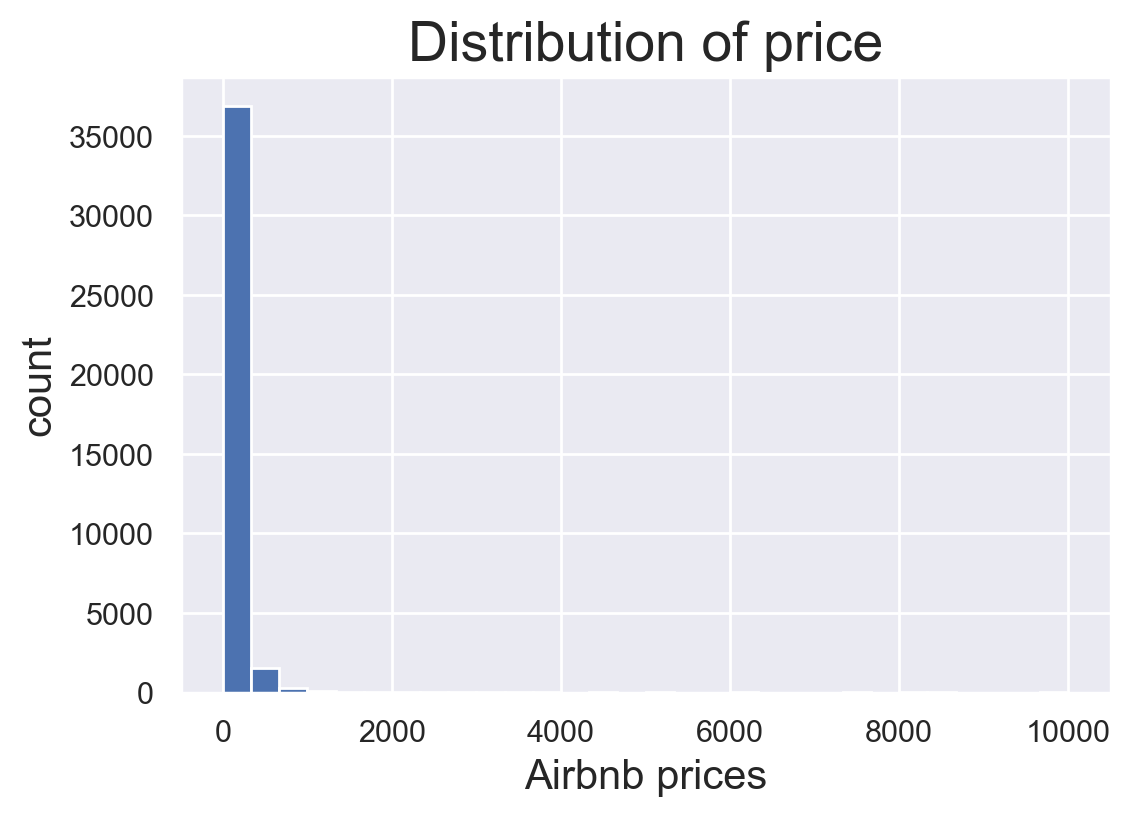

In [7]:
sns.set(rc={'figure.figsize':(6,4)})
plt.hist(df['price'], bins=30)
plt.xlabel("Airbnb prices", size=15)
plt.ylabel('count', size=15)
plt.title('Distribution of price', size=20)
plt.show()

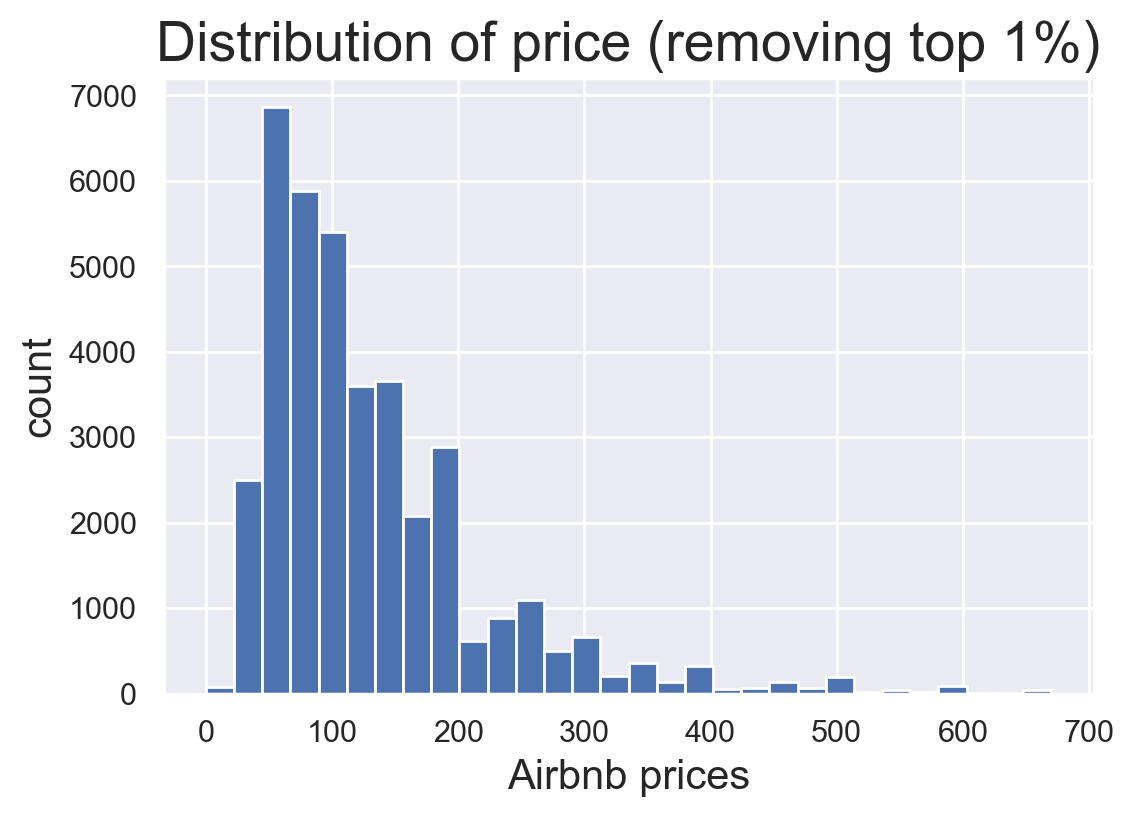

In [8]:
price_threshold = np.percentile(df.price, 99)
df = df[df['price'] < price_threshold]

sns.set(rc={'figure.figsize':(6,4)})
plt.hist(df['price'], bins=30)
plt.xlabel("Airbnb prices", size=15)
plt.ylabel('count', size=15)
plt.title('Distribution of price (removing top 1%)', size=20)
plt.show()

## Question 3: Create $X$ and $y$

Restrict the analysis to the following features:
```python
['latitude', 'longitude', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
```

In [9]:
X_full=df[['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]# 'room_type',
y_full= df['price']

n_samples = X_full.shape[0]
n_features = X_full.shape[1]
print(n_samples, n_features)

38432 7


## Question 4: Prepare Training and Test Sets using `train_test_split`
Pure ramdomness of the sampling method

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size=0.2, random_state=1)

print("train data", X_train.shape, y_train.shape)
print("test data", X_test.shape,  y_test.shape)

train data (30745, 7) (30745,)
test data (7687, 7) (7687,)


## Question 5: Scale the features using `StandardScaler`

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Question 6: Train a linear Model
- select a linear model (e.g. `LinearRegression`)
- fit the model on the training set
- predict the price on the test set
- compare the predicted price with the actual price
- evaluate the model using `mean_squared_error` and `r2_score`

In [12]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg

LinearRegression()

In [13]:
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [14]:
y_pred = lin_reg.predict(X_test_scaled)
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_test, y_pred)

In [15]:
print("R-squared for training dataset:{}".
      format(np.round(lin_reg.score(X_train_scaled, y_train), 2)))

R-squared for training dataset:0.11


In [16]:
print("R-squared for test dataset:{}".
      format(np.round(lin_reg.score(X_test_scaled, y_test), 2)))

R-squared for test dataset:0.1


Note: $R^2 =$ **the proportion of variance (of $y$) that has been explained by the independent variables in the model**. 


## Question 7: implement a 5 fold cross-validation to estimate the performance of the model

In [17]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold

In [18]:
# Perform 5-fold cross validation
scores = cross_val_score(lin_reg, X_train_scaled, y_train, 
                         scoring="neg_mean_squared_error", # evaluation metrics
                         cv=5)
scores

array([-7678.65890404, -7635.8473455 , -7455.64527617, -6989.87355251,
       -7819.38642987])

In [19]:
# the other way of doing the same thing (more explicit)

# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lin_reg, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=folds)
scores   

array([-7958.91340329, -7542.75700029, -7388.87485868, -7426.18337283,
       -7259.36070366])